# `PROYECTO NLP`

 Se trata de un problema de clasificación multietiqueta en el que tenéis que etiquetar un conjunto
de tweets de acuerdo a 11 sentimientos ('anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
'optimism', 'pessimism', 'sadness', 'surprise', 'trust').

Disponéis de un conjunto de 3561 tweets para entrenar el modelo o modelos necesarios, en el archivo
'sem_eval_train_es.csv'.

 Cada grupo tiene que validar sus modelos sobre un conjunto ciego de test con el nombre
‘sem_eval_test_blank_es.csv'. Cada Tweet tiene un ID (primera columna) que tenéis que mantener en
vuestra solución. Debéis aplicar vuestro modelo entrenado a este conjunto y guardarlo en un archivo CSV de
nombre ‘soluciones_grupo_N.csv' donde N es el nº asignado al grupo.

# `ESQUEMA DEL PROCESO:`

Clasificación Multietiqueta de Tweets

`1. Entender el problema y preparar el entorno`

-Clasificación multietiqueta: Etiquetar tweets con uno o más sentimientos.

-Datos: Archivos sem_eval_train_es.csv (entrenamiento) y sem_eval_test_blank_es.csv (test).

`2. Carga y exploración de los datos`

-Cargar los datos y entender su estructura (columnas, etiquetas, texto).

-Realizar un análisis exploratorio para verificar datos faltantes, distribuciones, etc.

`3. Preprocesamiento de los datos`

-Limpiar los textos: eliminar menciones, hashtags, URLs, puntuación, y convertir a minúsculas.

-Normalización del texto.


-Ordenar el DataFrame tratado.

`4. Preparar las etiquetas para multietiqueta`

-Convertir etiquetas a formato binario o one-hot encoding.

-Balanceo de etiquetas mediante sobremuestreo (En nuestro caso sobreajusta)

-Verificar el balanceo y el orden de los índices. (Si se llevase a cabo y fuera factible a nuestro caso de uso)

`5. División de los datos`

-Dividir el conjunto de entrenamiento en entrenamiento/validación.

-Vectorización con TF-IDF.

`6. Construir y entrenar el modelo`

-Seleccionar un modelo de clasificación multietiqueta.

-Ajustar hiperparámetros y entrenar.

-Predicciones sobre el conjunto de prueba.

`7. Evaluación del modelo`

-Validar el modelo: f1_score, accuracy, hamming_loss.

`8. Aplicar el modelo al conjunto de prueba`

-Preprocesar los tweets de sem_eval_test_blank_es.csv.

-Generar predicciones para este conjunto.

`9. Guardar las predicciones`

-Crear un archivo soluciones_grupo_N.csv con el formato correcto (ID y etiquetas predichas en fomato bool).

# EXPLORACIÓN, LIMPIEZA Y PREPROCESAMIENTO

In [ ]:
# Librerías necesarias
import pandas as pd
import numpy as np
import re
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score, hamming_loss

!pip install joblib
import joblib

In [ ]:
# Carga y exploración de datos

df_train = pd.read_csv('sem_eval_train_es.csv')
df_test_blank = pd.read_csv('sem_eval_test_blank_es.csv')

In [ ]:
# Descargar modelo de spaCy en español

!python -m spacy download es_core_news_md
nlp = spacy.load("es_core_news_md")
spanish_stopwords = list(nlp.Defaults.stop_words)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 14.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
df_train.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,@aliciaenp Ajajjaa somos del clan twitteras pe...,False,False,False,False,True,False,False,False,False,False,False
1,2018-Es-05142,@AwadaNai la mala suerte del gato fichame la c...,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-05379,@audiomano A mí tampoco me agrado mucho eso. E...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-00208,Para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-01385,@DalasReview me encanta la terrible hipocresia...,True,False,True,False,False,False,False,False,False,False,False


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561 entries, 0 to 3560
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            3561 non-null   object
 1   Tweet         3561 non-null   object
 2   anger         3561 non-null   bool  
 3   anticipation  3561 non-null   bool  
 4   disgust       3561 non-null   bool  
 5   fear          3561 non-null   bool  
 6   joy           3561 non-null   bool  
 7   love          3561 non-null   bool  
 8   optimism      3561 non-null   bool  
 9   pessimism     3561 non-null   bool  
 10  sadness       3561 non-null   bool  
 11  surprise      3561 non-null   bool  
 12  trust         3561 non-null   bool  
dtypes: bool(11), object(2)
memory usage: 94.0+ KB


In [ ]:
df_train.isna().sum()

,0
ID,0
Tweet,0
anger,0
anticipation,0
disgust,0
fear,0
joy,0
love,0
optimism,0
pessimism,0


In [ ]:
df_train.shape

(3561, 13)

In [ ]:
df_train.columns

Index(['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
      dtype='object')

In [ ]:
df_train.describe()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
count,3561,3561,3561,3561,3561,3561,3561,3561,3561,3561,3561,3561,3561
unique,3561,3561,2,2,2,2,2,2,2,2,2,2,2
top,2018-Es-01643,@aliciaenp Ajajjaa somos del clan twitteras pe...,False,False,False,False,False,False,False,False,False,False,False
freq,1,1,2406,3146,3040,3188,2474,3300,3183,2983,2716,3392,3386


In [ ]:
df_train.dtypes

,0
ID,object
Tweet,object
anger,bool
anticipation,bool
disgust,bool
fear,bool
joy,bool
love,bool
optimism,bool
pessimism,bool


In [ ]:
df_train.duplicated().sum()

0

**LIMPIEZA**

In [ ]:
import re
import string

pattern1 = re.compile(r'@[\w_]+') #elimina menciones
pattern2 = re.compile(r'https?://[\w_./]+') #elimina URL
pattern3 = re.compile(r'#[\w_]+') #elimina hashtags
pattern4 = re.compile('[{}]+'.format(re.escape(string.punctuation))) #elimina símbolos de puntuación
pattern5 = re.compile(
    r'[\U0001F600-\U0001F64F'  # emoticonos
    r'\U0001F300-\U0001F5FF'  # símbolos y pictogramas
    r'\U0001F680-\U0001F6FF'  # transportes y mapas
    r'\U0001F700-\U0001F77F'  # símbolos diversos
    r'\U0001F780-\U0001F7FF'  # otras representaciones
    r'\U0001F800-\U0001F8FF'  # más símbolos
    r'\U0001F900-\U0001F9FF'  # emojis de personas
    r'\U0001FA00-\U0001FA6F'  # más símbolos
    r'\U0001FA70-\U0001FAFF'  # más emojis
    r'\U00002702-\U000027B0'  # símbolos de acciones
    r'\U000024C2-\U0001F251]+', flags=re.UNICODE)
pattern6 = re.compile(r'^\s+|\s+$') #elimina espación en blanco al principio y final de la cadena de texto.
pattern7 = re.compile(r'[^\w\sáéíóúÁÉÍÓÚ:]') #elimina caractéres especiales, la Ñ Y ñ, se mantienen.


def clean_text(text):

    """Limpiamos las menciones, URL y hashtags del texto. Luego
    quitamos signos de puntuación"""
    text = pattern5.sub('', text)
    text = pattern1.sub('mención', text)
    text = pattern2.sub('URL', text)
    text = pattern3.sub('hashtag', text)
    text = pattern4.sub(' ', text)
    text = pattern6.sub('', text)
    text = pattern7.sub('', text)

    text = text.lower()

    return text

In [ ]:
df_train['Tweet'] = df_train['Tweet'].apply(clean_text)

In [ ]:
df_train.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,mención ajajjaa somos del clan twitteras perdi...,False,False,False,False,True,False,False,False,False,False,False
1,2018-Es-05142,mención la mala suerte del gato fichame la car...,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-05379,mención a mí tampoco me agrado mucho eso espe...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-00208,para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-01385,mención me encanta la terrible hipocresia y do...,True,False,True,False,False,False,False,False,False,False,False


In [ ]:
columnas = [col for col in df_train.columns if col not in ['ID', 'Tweet']]
print(columnas)

['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']


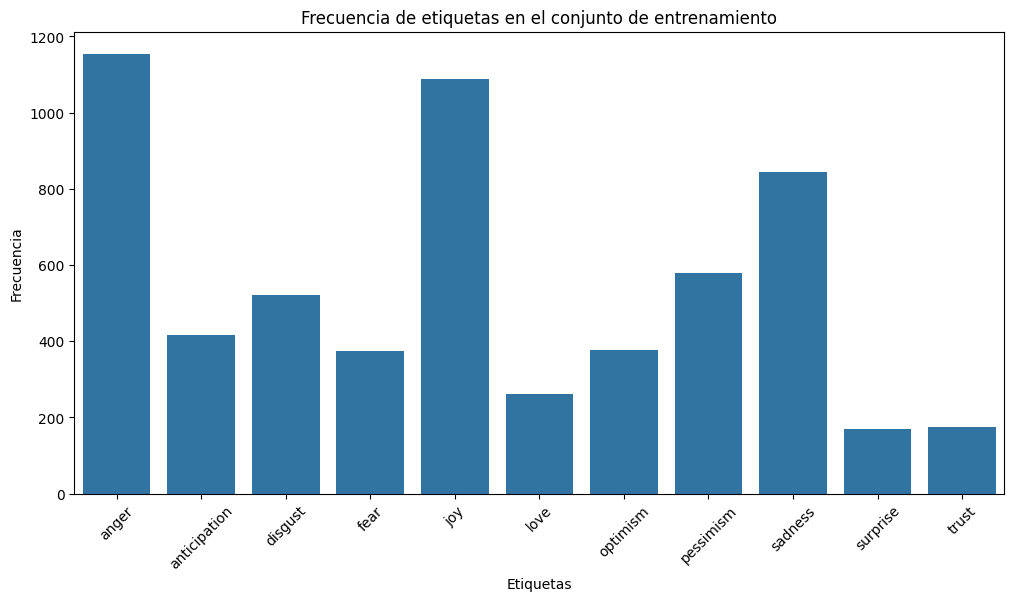

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Vemos el balanceo de los sentimientos y vemos que está desbalanceado, pero en nuestro caso haciendo un balanceo previo obtenemos sobreajuste.

# Crear un DataFrame con las frecuencias de las etiquetas
frequencies = df_train[columnas].sum().reset_index()
frequencies.columns = ['Etiqueta', 'Frecuencia']

# Visualizar con un gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='Etiqueta', y='Frecuencia', data=frequencies)
plt.title('Frecuencia de etiquetas en el conjunto de entrenamiento')
plt.xlabel('Etiquetas')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

**NORMALIZACIÓN**

Es un paso fundamental para limpiar y preparar los datos y mejorar el rendimiento de los modelos de clasificación de texto, como es nuestro caso para la clasificación multietiqueta.

`Tokeniza el texto usando spaCy`

`Convertimos todas las palabras a minúsculas → t.lower_`


`Elimina los espacios (t.is_space) y la puntuación (t.is_punct)`

`Devuelve el texto limpio en una sola cadena de texto`


In [ ]:
# Si aquí eliminaramos las palabras de menos de 3 caracteres eliminariamos los 'No' y los 'Si' que para el análisis de sentimiento es importante.
# Hecha la prueba eliminando y manteniéndolas, las métricas mejoran un poquito (no es un aumento significativo pero hay algo de mejora)

def normalizar_doc (doc):
    tokens = nlp(doc)
    # Preservamos todas las palabras, incluso cortas
    filtered_tokens = [t.lower_ for t in tokens if not t.is_space and not t.is_punct]
    return ' '.join(filtered_tokens)
    return doc

In [ ]:
df_train['Tweet_normalizado'] = df_train['Tweet'].apply(normalizar_doc)

df_train

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,Tweet_normalizado
0,2018-Es-01643,mención ajajjaa somos del clan twitteras perdi...,False,False,False,False,True,False,False,False,False,False,False,mención ajajjaa somos del clan twitteras perdi...
1,2018-Es-05142,mención la mala suerte del gato fichame la car...,False,False,False,True,False,False,False,True,False,False,False,mención la mala suerte del gato fichame la car...
2,2018-Es-05379,mención a mí tampoco me agrado mucho eso espe...,True,False,False,False,False,False,False,False,False,False,False,mención a mí tampoco me agrado mucho eso espec...
3,2018-Es-00208,para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False,para llevar a los bebes de un lugar a otro deb...
4,2018-Es-01385,mención me encanta la terrible hipocresia y do...,True,False,True,False,False,False,False,False,False,False,False,mención me encanta la terrible hipocresia y do...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556,2018-Es-06340,ahorita quisiera que mi preocupación más grand...,False,False,False,True,False,False,False,True,True,False,False,ahorita quisiera que mi preocupación más grand...
3557,2018-Es-00439,el mayor criminal del país diciéndole delincue...,True,False,True,False,False,False,False,False,False,False,False,el mayor criminal del país diciéndole delincue...
3558,2018-Es-04919,mi prima de 4 años se ha enfadado conmigo porq...,True,False,False,False,False,False,False,False,False,True,False,mi prima de 4 años se ha enfadado conmigo porq...
3559,2018-Es-02703,mención jajaja ya seee,False,False,False,False,True,False,False,False,False,False,False,mención jajaja ya seee


In [ ]:
#Sobre df_train pasar columna Tweet_normalizado a posición 1 y eliminar columna Tweet

# mover 'Tweet_normalizado' columna a posición 1
cols = list(df_train.columns)
cols.insert(1, cols.pop(cols.index('Tweet_normalizado')))
df_work = df_train.loc[:, cols]

# Borrar columna 'Tweet'
del df_work['Tweet']

df_work

,ID,Tweet_normalizado,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,mención ajajjaa somos del clan twitteras perdi...,False,False,False,False,True,False,False,False,False,False,False
1,2018-Es-05142,mención la mala suerte del gato fichame la car...,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-05379,mención a mí tampoco me agrado mucho eso espec...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-00208,para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-01385,mención me encanta la terrible hipocresia y do...,True,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556,2018-Es-06340,ahorita quisiera que mi preocupación más grand...,False,False,False,True,False,False,False,True,True,False,False
3557,2018-Es-00439,el mayor criminal del país diciéndole delincue...,True,False,True,False,False,False,False,False,False,False,False
3558,2018-Es-04919,mi prima de 4 años se ha enfadado conmigo porq...,True,False,False,False,False,False,False,False,False,True,False
3559,2018-Es-02703,mención jajaja ya seee,False,False,False,False,True,False,False,False,False,False,False


In [ ]:
# df_work renombrar la columna posición 1 a 'Tweet'
df_work_Nor = df_work.rename(columns={df_work.columns[1]: 'Tweet'})
df_work_Nor

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,mención ajajjaa somos del clan twitteras perdi...,False,False,False,False,True,False,False,False,False,False,False
1,2018-Es-05142,mención la mala suerte del gato fichame la car...,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-05379,mención a mí tampoco me agrado mucho eso espec...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-00208,para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-01385,mención me encanta la terrible hipocresia y do...,True,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556,2018-Es-06340,ahorita quisiera que mi preocupación más grand...,False,False,False,True,False,False,False,True,True,False,False
3557,2018-Es-00439,el mayor criminal del país diciéndole delincue...,True,False,True,False,False,False,False,False,False,False,False
3558,2018-Es-04919,mi prima de 4 años se ha enfadado conmigo porq...,True,False,False,False,False,False,False,False,False,True,False
3559,2018-Es-02703,mención jajaja ya seee,False,False,False,False,True,False,False,False,False,False,False


In [ ]:
# Identificar las columnas de emociones manualmente
emotion_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                   'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

In [ ]:
# Convertir valores booleanos a binario (0 y 1)
for col in emotion_columns:
    df_work_Nor[col] = df_work_Nor[col].apply(lambda x: 1 if x else 0)

In [ ]:
# Confirmar la conversión
print("\nEtiquetas convertidas a binario (0 y 1):")
print(df_work_Nor[emotion_columns].head())


Etiquetas convertidas a binario (0 y 1):
   anger  anticipation  disgust  fear  joy  love  optimism  pessimism  \
0      0             0        0     0    1     0         0          0   
1      0             0        0     1    0     0         0          1   
2      1             0        0     0    0     0         0          0   
3      0             0        0     0    1     0         0          0   
4      1             0        1     0    0     0         0          0   

   sadness  surprise  trust  
0        0         0      0  
1        0         0      0  
2        0         0      0  
3        0         0      0  
4        0         0      0  


In [ ]:
df_work_Nor.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,mención ajajjaa somos del clan twitteras perdi...,0,0,0,0,1,0,0,0,0,0,0
1,2018-Es-05142,mención la mala suerte del gato fichame la car...,0,0,0,1,0,0,0,1,0,0,0
2,2018-Es-05379,mención a mí tampoco me agrado mucho eso espec...,1,0,0,0,0,0,0,0,0,0,0
3,2018-Es-00208,para llevar a los bebes de un lugar a otro deb...,0,0,0,0,1,0,0,0,0,0,0
4,2018-Es-01385,mención me encanta la terrible hipocresia y do...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Confirmar la distribución de etiquetas
print("\nDistribución de etiquetas en el conjunto de entrenamiento:")
print(df_work_Nor[emotion_columns].sum())


Distribución de etiquetas en el conjunto de entrenamiento:
anger           1155
anticipation     415
disgust          521
fear             373
joy             1087
love             261
optimism         378
pessimism        578
sadness          845
surprise         169
trust            175
dtype: int64


In [ ]:
df_work_Nor.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,mención ajajjaa somos del clan twitteras perdi...,0,0,0,0,1,0,0,0,0,0,0
1,2018-Es-05142,mención la mala suerte del gato fichame la car...,0,0,0,1,0,0,0,1,0,0,0
2,2018-Es-05379,mención a mí tampoco me agrado mucho eso espec...,1,0,0,0,0,0,0,0,0,0,0
3,2018-Es-00208,para llevar a los bebes de un lugar a otro deb...,0,0,0,0,1,0,0,0,0,0,0
4,2018-Es-01385,mención me encanta la terrible hipocresia y do...,1,0,1,0,0,0,0,0,0,0,0


# DIVISIÓN, VECTORIZACIÓN Y ENTRENAMIENTO

In [ ]:
# División de datos y vectorización

# Variables independientes (texto) y dependientes (etiquetas)
X = df_work_Nor['Tweet']
y = df_work_Nor[emotion_columns]

In [ ]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Confirmar las dimensiones y los tipos de datos de y_train
print(f"Dimensiones de y_train: {y_train.shape}")
print(f"Tipos de datos: {y_train.dtypes}")

# Revisar los valores únicos en cada columna de emociones
for col in emotion_columns:
    print(f"Valores únicos en '{col}': {y_train[col].unique()}")

Dimensiones de y_train: (2848, 11)
Tipos de datos: anger           int64
anticipation    int64
disgust         int64
fear            int64
joy             int64
love            int64
optimism        int64
pessimism       int64
sadness         int64
surprise        int64
trust           int64
dtype: object
Valores únicos en 'anger': [0 1]
Valores únicos en 'anticipation': [0 1]
Valores únicos en 'disgust': [0 1]
Valores únicos en 'fear': [0 1]
Valores únicos en 'joy': [1 0]
Valores únicos en 'love': [0 1]
Valores únicos en 'optimism': [0 1]
Valores únicos en 'pessimism': [0 1]
Valores únicos en 'sadness': [0 1]
Valores únicos en 'surprise': [0 1]
Valores únicos en 'trust': [0 1]


**VECTORIZACIÓN TF-IDF**

`Transforma el texto en vectores numéricos`

Los modelos de Machine Learning necesitan datos numéricos. TF-IDF convierte los tweets en matrices de características, donde cada fila representa un tweet y cada columna representa una palabra del vocabulario.

`Reduce el impacto de palabras comunes (stopwords)`

TF (Term Frequency): Cuenta cuántas veces aparece una palabra en un documento.
IDF (Inverse Document Frequency): Reduce la importancia de palabras demasiado frecuentes en todo el corpus, como “el”, “de”, “y”, que no aportan información relevante.
Esto ayuda a dar más peso a palabras clave que realmente diferencian los sentimientos.

`Mejora la precisión en la clasificación`

Al eliminar el ruido de palabras comunes y dar más peso a términos distintivos, los modelos pueden aprender patrones más claros en los datos.

`Es más eficiente computacionalmente que Word Embeddings como Word2Vec o BERT`

Como trabajas con un dataset de tweets relativamente pequeño (3561 tweets de entrenamiento), TF-IDF es una opción eficiente y rápida, sin necesidad de entrenar grandes modelos de embeddings.

`Funciona bien con modelos tradicionales de Machine Learning`

Dado que probablemente estés probando modelos como Logistic Regression, SVM o Random Forest, TF-IDF es una opción efectiva, ya que estos modelos funcionan bien con representaciones dispersas de texto.

**¿POR QUÉ PRIMERO SE DIVIDE EL CONJUNTO DE DATOS Y DESPUÉS SE VECTORIZA?**

Razón principal: Evitar Data Leakage

Data leakage ocurre cuando información del conjunto de prueba influye en el entrenamiento del modelo, lo que hace que los resultados sean demasiado optimistas y poco realistas.

Si vectorizas primero con TF-IDF usando todo el conjunto de datos antes de dividirlo en entrenamiento y prueba, el modelo estará aprendiendo de información que también está en el test set, lo que provoca una evaluación irreal.

De esta manera:

El vectorizador solo aprende de los datos de entrenamiento.

No hay filtración de información del test set en el entrenamiento.

Se simula mejor un escenario real, donde el modelo debe generalizar a nuevos datos.

**GUARDADO**

`Guardar Vectorizado`

El paso de guardar el vectorizador ajustado (TfidfVectorizer) después de transformarlo en el conjunto de entrenamiento es necesario para poder aplicar predicciones en el conjunto de prueba de manera consistente. Este vectorizador contiene las estadísticas de las palabras del conjunto de entrenamiento (como las frecuencias inversas de documentos) que son esenciales para calcular las representaciones TF-IDF en el conjunto de prueba.

`Razón:`

Si no guardamos el vectorizador después de ajustar el conjunto de entrenamiento y lo volvemos a ajustar con el conjunto de prueba, las estadísticas de las palabras cambiarán, lo que resultará en representaciones inconsistentes y predicciones incorrectas.

In [ ]:
# Vectorización con TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words=spanish_stopwords, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
# Guardar el vectorizador
joblib.dump(tfidf, 'vectorizer.pkl')

['vectorizer.pkl']

**ENTRENAMIENTO DEL MODELO**

Se utiliza LogisticRegression como clasificador base dentro de MultiOutputClassifier para manejar la clasificación multietiqueta, ya que permite predecir múltiples etiquetas de manera independiente.

`Parámetros iniciales de LogisticRegression:`

- class_weight='balanced': Ajusta automáticamente los pesos de cada clase para compensar cualquier desequilibrio en las etiquetas, lo que mejora la capacidad del modelo para manejar clases desbalanceadas.
- max_iter=500: Aumentamos el número máximo de iteraciones para garantizar que el algoritmo converja, especialmente cuando se combinan regularización y múltiples clases.
- random_state=42: Se fija una semilla para garantizar reproducibilidad de los resultados.

`Se usa GridSearchCV para optimizar los hiperparámetros` con las siguientes configuraciones:

- scoring='f1_micro': Se optimiza el F1-score en su versión "micro", ya que permite manejar el desbalance de clases y es adecuado para múltiples etiquetas.
- cv=3: Se emplea validación cruzada con 3 folds para evaluar la estabilidad del modelo en diferentes particiones de los datos.
- verbose=1: Se habilita la salida de logs para monitorear el proceso de búsqueda.
- n_jobs=-1: Se utilizan todos los núcleos disponibles en la CPU para acelerar el proceso de búsqueda.



In [ ]:
# Configurar el clasificador base
base_clf = LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)
clf = MultiOutputClassifier(base_clf)

In [ ]:
# Definir el espacio de búsqueda de hiperparámetros

param_grid = {
    'estimator__penalty': ['l2', 'l1'],  # Tipo de regularización para controlar la complejidad del modelo.
    'estimator__C': [0.01, 0.1, 1, 10, 100],  # Controla la fuerza de regularización: valores pequeños implican mayor regularización.
    'estimator__solver': ['lbfgs', 'saga'],  # Métodos de optimización compatibles con la regularización seleccionada.
    'estimator__class_weight': ['balanced']  # Mantiene el ajuste automático de pesos en cada iteración.
}

In [ ]:
from sklearn.model_selection import GridSearchCV
# Configurar GridSearchCV
grid_search = GridSearchCV(
    MultiOutputClassifier(base_clf),
    param_grid,
    scoring='f1_micro',  # Métrica para optimizar
    cv=3,                # Número de folds para validación cruzada
    verbose=1,
    n_jobs=-1            # Usar todos los núcleos disponibles
)

In [ ]:
# Entrenar el modelo
grid_search.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/multioutput.py", line 543, in fit
    super().fit(X, Y, sample_weight=sample_weight, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^

GridSearchCV(cv=3,
             estimator=MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                          max_iter=500,
                                                                          random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__C': [0.01, 0.1, 1, 10, 100],
                         'estimator__class_weight': ['balanced'],
                         'estimator__penalty': ['l2', 'l1'],
                         'estimator__solver': ['lbfgs', 'saga']},
             scoring='f1_micro', verbose=1)

In [ ]:
# Mostrar los mejores hiperparámetros
# Seleccionar el mejor estimador

print("Mejores hiperparámetros:", grid_search.best_params_)
clf = grid_search.best_estimator_

Mejores hiperparámetros: {'estimator__C': 1, 'estimator__class_weight': 'balanced', 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}


In [ ]:
# Guardar el modelo entrenado, para las futuras predicciones
# Las predicciones dependen del modelo guardado, por lo que se guarda antes de realizar cualquier predicción

joblib.dump(clf, 'clf.pkl')

['clf.pkl']

In [ ]:
# Predicciones

y_pred = clf.predict(X_test_tfidf)

In [ ]:
y_pred_train = clf.predict(X_train_tfidf)

# RESULTADO DE LAS MÉTRICAS DE TEST Y TRAIN

In [ ]:
from sklearn.metrics import classification_report

# Calcular métricas en el conjunto de entrenamiento

print("Métricas por clase en train:")
print(classification_report(y_train, y_pred_train, target_names=emotion_columns))

Métricas por clase en train:
              precision    recall  f1-score   support

       anger       0.88      0.94      0.91       933
anticipation       0.68      0.98      0.80       327
     disgust       0.74      0.98      0.85       430
        fear       0.78      0.98      0.87       307
         joy       0.86      0.93      0.89       872
        love       0.74      0.98      0.84       214
    optimism       0.65      0.98      0.78       295
   pessimism       0.67      0.96      0.79       456
     sadness       0.82      0.92      0.87       688
    surprise       0.76      0.98      0.86       129
       trust       0.64      0.99      0.77       138

   micro avg       0.77      0.95      0.85      4789
   macro avg       0.75      0.97      0.84      4789
weighted avg       0.78      0.95      0.86      4789
 samples avg       0.79      0.91      0.83      4789



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Calcular métricas en el conjunto de entrenamiento

from sklearn.metrics import f1_score

f1_micro_train = f1_score(y_train, y_pred_train, average='micro')
f1_macro_train = f1_score(y_train, y_pred_train, average='macro')
print(f"F1-Score (micro) en train: {f1_micro_train:.3f}")
print(f"F1-Score (macro) en train: {f1_macro_train:.3f}")

F1-Score (micro) en train: 0.853
F1-Score (macro) en train: 0.838


In [ ]:
# Métricas en el conjunto de prueba

print("Métricas por clase en test:")
print(classification_report(y_test, y_pred, target_names=emotion_columns))

Métricas por clase en test:
              precision    recall  f1-score   support

       anger       0.59      0.61      0.60       222
anticipation       0.27      0.36      0.31        88
     disgust       0.31      0.43      0.36        91
        fear       0.51      0.68      0.58        66
         joy       0.62      0.67      0.65       215
        love       0.40      0.49      0.44        47
    optimism       0.31      0.34      0.32        83
   pessimism       0.33      0.43      0.37       122
     sadness       0.51      0.60      0.55       157
    surprise       0.24      0.25      0.24        40
       trust       0.24      0.27      0.25        37

   micro avg       0.45      0.52      0.48      1168
   macro avg       0.39      0.47      0.43      1168
weighted avg       0.46      0.52      0.49      1168
 samples avg       0.45      0.54      0.45      1168



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Métricas en el conjunto de prueba

f1_micro_test = f1_score(y_test, y_pred, average='micro')
f1_macro_test = f1_score(y_test, y_pred, average='macro')
print(f"F1-Score (micro) en test: {f1_micro_test:.3f}")
print(f"F1-Score (macro) en test: {f1_macro_test:.3f}")

F1-Score (micro) en test: 0.483
F1-Score (macro) en test: 0.426


In [ ]:
# Revisar el formato y dimensiones

print(f"Dimensiones de y_test: {y_test.shape}")
print(f"Dimensiones de y_pred: {y_pred.shape}")

print(f"Valores únicos en y_test: {np.unique(y_test)}")
print(f"Valores únicos en y_pred: {np.unique(y_pred)}")

Dimensiones de y_test: (713, 11)
Dimensiones de y_pred: (713, 11)
Valores únicos en y_test: [0 1]
Valores únicos en y_pred: [0 1]


**CONCLUSIONES**

`¿Overfitting o simplemente un problema difícil?`

A primera vista, parece haber overfitting porque:

F1-micro en Train: 0.853

F1-micro en Test: 0.483

Caída significativa de -0.37.

Sin embargo, si el problema es naturalmente difícil, puede que el modelo simplemente no logre una generalización perfecta, lo cual no es un problema si es esperado.

`¿Qué podría estar afectando el rendimiento?`

**Dificultad del problema:**

Clasificación multietiqueta de emociones es complicada, incluso para modelos avanzados.

La subjetividad en los tweets hace que algunos ejemplos sean ambiguos.

**Desbalance de Clases:**

Algunas emociones tienen pocos ejemplos, lo que dificulta su predicción.

Las emociones menos representadas tienen peor F1-score.

**Modelo Basado en TF-IDF + MultiOutputClassifier:**

TF-IDF ignora el contexto, por lo que el modelo no capta la semántica completa.
MultiOutputClassifier trata cada emoción de forma independiente, cuando en realidad algunas emociones tienen correlaciones (ejemplo: tristeza y pesimismo pueden aparecer juntas).



# EVALUACIÓN DEL MODELO

In [ ]:
# Evaluar el modelo

from sklearn.metrics import f1_score, accuracy_score, hamming_loss

# Calcular métricas
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_samples = f1_score(y_test, y_pred, average='samples')
accuracy = accuracy_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)

# Mostrar resultados
print(f"F1-Score (micro): {f1_micro}")
print(f"F1-Score (samples): {f1_samples}")
print(f"Accuracy: {accuracy}")
print(f"Hamming Loss: {hamming}")

F1-Score (micro): 0.48322147651006714
F1-Score (samples): 0.45408401789888475
Accuracy: 0.15988779803646563
Hamming Loss: 0.16690042075736325


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**MÉTRICAS**

La métrica más importante es F1-Score (micro), ya que refleja el equilibrio entre precisión y recall en clasificación multietiqueta.

`F1-Score (micro) = 0.483`

Interpretación: Indica un rendimiento moderado, ya que toma en cuenta la precisión y el recall de todas las etiquetas globalmente.

Conclusión: El modelo es capaz de capturar patrones, pero no con gran precisión. Es la métrica más confiable en este caso.

`F1-Score (samples) = 0.454`

Interpretación: Evalúa la calidad de las predicciones en cada tweet individualmente.

Conclusión: Similar a F1-micro, pero muestra que en algunos tweets con múltiples etiquetas, el modelo no predice correctamente todas.

`Accuracy = 0.159`

Interpretación: Muy baja, pero en clasificación multietiqueta no es la mejor métrica, ya que solo cuenta como correcto un tweet si todas sus etiquetas son predichas correctamente.

Conclusión: No es preocupante. En multietiqueta, accuracy suele ser baja y no es representativa del rendimiento real.

`Hamming Loss = 0.166`

Interpretación: Mide el error por etiqueta, indicando que en promedio hay un 17% de predicciones incorrectas por etiqueta.

Conclusión: No es un valor catastrófico, pero sugiere que hay margen de mejora, especialmente en etiquetas menos representadas.

**CONCLUSIÓN GLOBAL:**

El modelo tiene un rendimiento aceptable dado un problema difícil.

F1-Score (micro) es la métrica más representativa y muestra que el modelo logra identificar emociones, aunque con limitaciones.

Accuracy no es relevante en este caso.

El Hamming Loss indica que hay errores, pero el modelo aún tiene capacidad de predicción.

No es un modelo perfecto, pero dentro de lo esperado. Se podría mejorar con embeddings, manejo del desbalance y modelos más avanzados.

# APLICAR EL MODELO AL CONJUNTO DE PRUEBA

`Limpieza del texto (clean_text):`

* Eliminación de menciones, URLs, hashtags, puntuaciones, emojis, y caracteres
especiales.
* Conversión del texto a minúsculas.

`Normalización con SpaCy (normalizar_doc):`

`Vectorización TF-IDF`

`Aplicación de estas funciones al dataset`

`Generar predicciones con el modelo cargado`

`Generar DataFrame con las predicciones`

`Comprobar nuestro DataFrame con los resultados`

In [ ]:
# Cargar datos de prueba
df_test_blank = pd.read_csv('sem_eval_test_blank_es.csv')

In [ ]:
df_test_blank.head()

,ID,Tweet
0,2018-Es-06697,No me pienso perder la pelea de McGregor contr...
1,2018-Es-05385,Yo preocupada pensando que mi papá ya había ll...
2,2018-Es-03777,Pucha ya no me sirven todos los carros a Rondi...
3,2018-Es-02175,"Si estar contigo es un delito, hago cien años ..."
4,2018-Es-00726,@macacifuentesC @sergmujica Perfect... Y de un...


In [ ]:
# Definir patrones de limpieza
pattern1 = re.compile(r'@[\w_]+')  # menciones
pattern2 = re.compile(r'https?://[\w_./]+')  # URLs
pattern3 = re.compile(r'#[\w_]+')  # hashtags
pattern4 = re.compile(f'[{re.escape(string.punctuation)}]+')  # puntuación
pattern5 = re.compile(
    r'[\U0001F600-\U0001F64F'
    r'\U0001F300-\U0001F5FF'
    r'\U0001F680-\U0001F6FF'
    r'\U0001F700-\U0001F77F'
    r'\U0001F780-\U0001F7FF'
    r'\U0001F800-\U0001F8FF'
    r'\U0001F900-\U0001F9FF'
    r'\U0001FA00-\U0001FA6F'
    r'\U0001FA70-\U0001FAFF'
    r'\U00002702-\U000027B0'
    r'\U000024C2-\U0001F251]+', flags=re.UNICODE)
pattern6 = re.compile(r'^\s+|\s+$')  # espacios extra
pattern7 = re.compile(r'[^\w\sáéíóúÁÉÍÓÚñÑ]')  # caracteres especiales

def clean_text(text):
    text = pattern5.sub('', text)
    text = pattern1.sub('mención', text)
    text = pattern2.sub('URL', text)
    text = pattern3.sub('hashtag', text)
    text = pattern4.sub(' ', text)
    text = pattern6.sub('', text)
    text = pattern7.sub('', text)
    text = text.lower()
    return text

In [ ]:
def normalize_text(text):
    tokens = nlp(text)
    filtered_tokens = [t.lower_ for t in tokens if not t.is_space and not t.is_punct]
    return ' '.join(filtered_tokens)
    return text

In [ ]:
# Aplicar limpieza y normalización en una sola columna
df_test_blank['Tweet'] = df_test_blank['Tweet'].apply(clean_text).apply(normalize_text)

In [ ]:
df_test_blank.head()

,ID,Tweet
0,2018-Es-06697,no me pienso perder la pelea de mcgregor contr...
1,2018-Es-05385,yo preocupada pensando que mi papá ya había ll...
2,2018-Es-03777,pucha ya no me sirven todos los carros a rondi...
3,2018-Es-02175,si estar contigo es un delito hago cien años e...
4,2018-Es-00726,mención mención perfect y de una mansa ni que ...


In [ ]:
# Cargar vectorizador
vectorizer = joblib.load('vectorizer.pkl')

# Transformar los datos de prueba
X_test_blank_tfidf = vectorizer.transform(df_test_blank['Tweet'])


In [ ]:
# Cargar modelo
model = joblib.load('clf.pkl')

# Generar predicciones
predictions = model.predict(X_test_blank_tfidf)

In [ ]:
# Crear un DataFrame con las predicciones
categories = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
# Agregar las predicciones al DataFrame original
predictions_df = pd.DataFrame(predictions, columns=categories)

In [ ]:
# Convertir predicciones a valores booleanos
predictions_df = predictions_df.astype(bool)

In [ ]:
# Agregar las predicciones al DataFrame original
#df_test_blank = pd.concat([df_test_blank, predictions_df], axis=1)

In [ ]:
# Combinar las predicciones con los IDs originales
predictions_df = pd.concat([df_test_blank['ID'], predictions_df], axis=1)

In [ ]:
# Verificar estructura del DataFrame
print(predictions_df.head())
print(predictions_df.columns)

              ID  anger  anticipation  disgust   fear    joy   love  optimism  \
0  2018-Es-06697  False          True    False  False  False  False     False   
1  2018-Es-05385  False         False    False   True  False  False     False   
2  2018-Es-03777  False         False     True   True  False  False     False   
3  2018-Es-02175  False         False    False  False  False  False     False   
4  2018-Es-00726   True         False     True  False  False  False     False   

   pessimism  sadness  surprise  trust  
0      False    False     False  False  
1       True    False     False  False  
2       True    False     False  False  
3      False    False      True  False  
4       True     True     False  False  
Index(['ID', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
       'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
      dtype='object')


In [ ]:
predictions_df.head()

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-06697,False,True,False,False,False,False,False,False,False,False,False
1,2018-Es-05385,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-03777,False,False,True,True,False,False,False,True,False,False,False
3,2018-Es-02175,False,False,False,False,False,False,False,False,False,True,False
4,2018-Es-00726,True,False,True,False,False,False,False,True,True,False,False


In [ ]:
# Guardar el archivo CSV con solo las predicciones
predictions_df.to_csv('soluciones_grupo_CAA_Sensia.csv', index=False, sep=',')

# CONCLUSIONES

**ANÁLISIS DE LAS MÉTRICAS EN EL CONJUNTO CIEGO**

`(FEBE)`

accuracy	0.2

f1_score	0.5

precision	0.5

`El F1-score (0.5)` indica un equilibrio moderado entre precisión y recall. Esto sugiere que el modelo logra identificar patrones en los datos, aunque aún tiene margen de mejora.

`La precisión (0.5)` muestra que el 50% de las predicciones que realiza el modelo son correctas. Esto es aceptable, pero podría optimizarse para reducir falsos positivos.

`Accuracy (0.2)` es baja, pero en clasificación multietiqueta esto es común. Esto se debe a que la accuracy solo considera una predicción como correcta si todas las etiquetas coinciden perfectamente con la verdad, lo cual es difícil en problemas donde un tweet puede tener múltiples etiquetas.



**CONCLUSIÓN GLOBAL**

El modelo logra extraer patrones de los datos, pero aún puede mejorarse en la predicción de etiquetas menos frecuentes.

La precisión y el F1-score muestran que el modelo tiene una capacidad moderada de hacer predicciones correctas, pero el desbalance puede estar afectando su rendimiento.

La baja accuracy no es un problema crítico, ya que en clasificación multietiqueta es difícil predecir exactamente todas las etiquetas correctas al mismo tiempo.

Para mejorar los resultados, se podrían probar técnicas como balanceo de clases, embeddings más avanzados y ajuste fino del modelo.

En resumen: El modelo tiene un rendimiento aceptable dentro de las limitaciones del problema y el desbalance de datos.

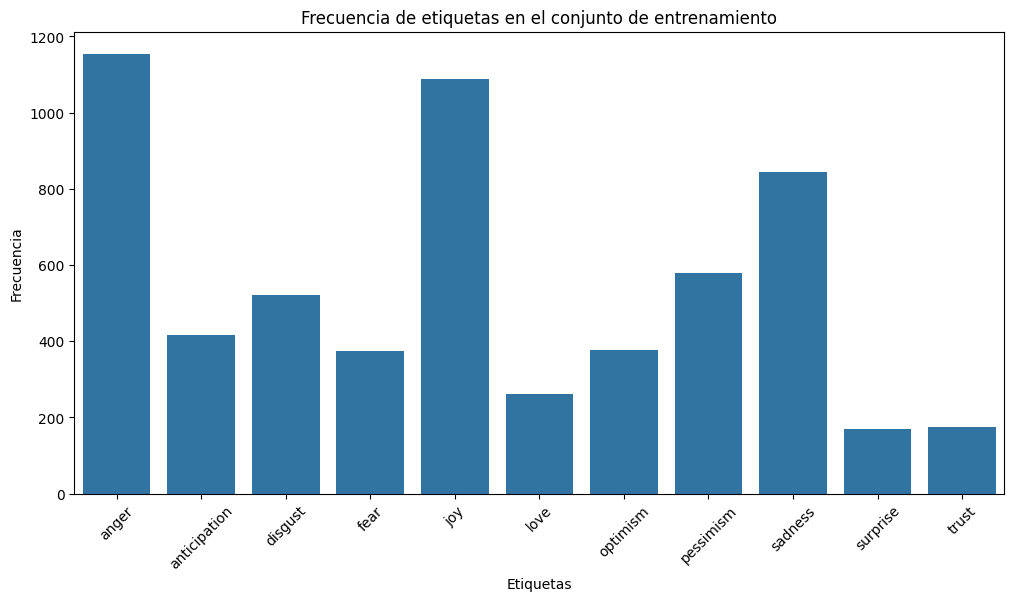

In [ ]:
# Crear un DataFrame con las frecuencias de las etiquetas (entrenamiento)
frequencies = df_train[columnas].sum().reset_index()
frequencies.columns = ['Etiqueta', 'Frecuencia']

# Visualizar con un gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='Etiqueta', y='Frecuencia', data=frequencies)
plt.title('Frecuencia de etiquetas en el conjunto de entrenamiento')
plt.xlabel('Etiquetas')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

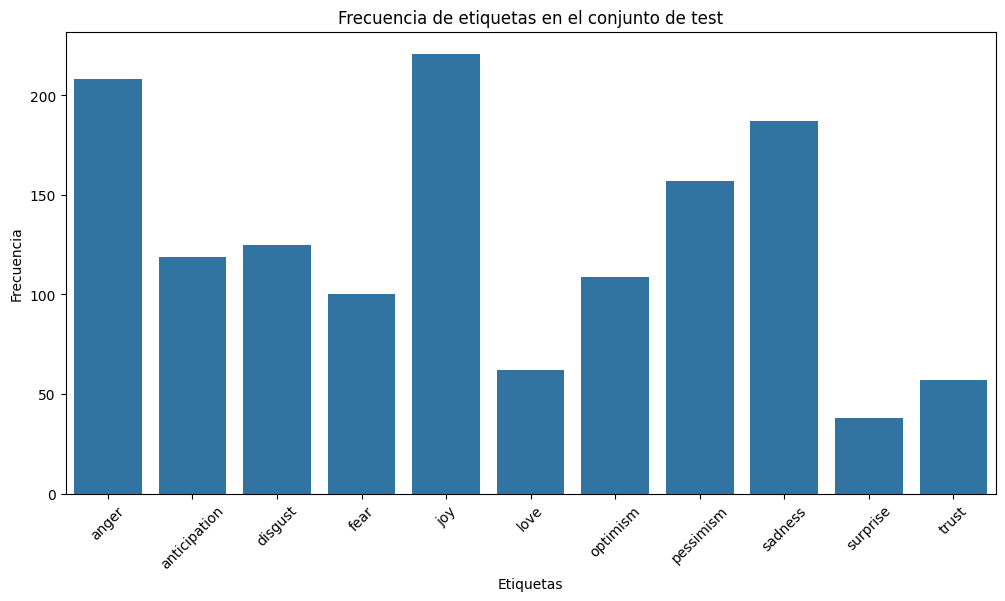

In [ ]:
# Crear un DataFrame con las frecuencias de las etiquetas (predicciones)
frequencies = predictions_df[columnas].sum().reset_index()
frequencies.columns = ['Etiqueta', 'Frecuencia']

# Visualizar con un gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='Etiqueta', y='Frecuencia', data=frequencies)
plt.title('Frecuencia de etiquetas en el conjunto de test')
plt.xlabel('Etiquetas')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()